# Experiment 3.1.4: Evaluating feature importance

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torcheval.metrics.functional import r2_score

from captum.attr import IntegratedGradients, Saliency, NoiseTunnel, InputXGradient, LRP, DeepLift
from captum.attr._utils.lrp_rules import EpsilonRule

#### Generate continuous and categorical data

In [2]:
def gen_data(num_features=20, num_samples=5000, type="Cont"):
    
    if type=="Cont":
        mue = np.random.uniform(-2, 2, (num_features, 1))
        sigma = np.random.uniform(np.sqrt(0.9), np.sqrt(1.1), (num_features, 1))

        X = np.random.normal(mue, sigma, size=(num_features, num_samples)).T
        X_one_hot_flattend = X
    else:
        X_label = np.random.choice(4, (num_samples, num_features))
        X = (X_label - (4 - 1) / 2) / ((4 - 1) / 2)
        X_one_hot = F.one_hot(torch.from_numpy(X_label)).numpy()
        X_one_hot_flattend = X_one_hot.reshape(X_one_hot.shape[0], -1)

    return X, X_one_hot_flattend

#### Define the transformation functions for continuous data

In [3]:
def g(X, func):
    if func == "Linear":
        return X
    elif func == "Non-continuous":
        X_proc = X.copy()
        for i in range(len(X)):
            for j in range(len(X[0])):
                if np.abs(X[i,j]) <= 1.5:
                    X_proc[i,j] = np.where(np.abs(X[i,j]) < 0.4, 1, -1)
                else:
                    X_proc[i,j] = np.sign(X[i,j]) * 0.05 * (X[i,j]**2 - 1.5**2) - 1
        return X_proc
    else:
        return X

#### Method to calculate the Y for the inputs

In [4]:
def calc_y(X, num_features, num_samples, func):

    epsilon = np.random.normal(0, 1, num_samples)

    beta = np.random.uniform(-1, 1, num_features + 1)
    beta[1:] = ([0, 1] * int(num_features / 2))
    
    Y = beta[0] + np.sum(np.multiply(beta[1:], g(X, func)), axis=1) + epsilon

    return Y, beta

#### Define the neural networks for continuous and categorical variables

In [5]:
class Net(nn.Module):

    def __init__(self, num_features):
        super(Net, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 1)
        )

    
    def forward(self, input):
        return self.net(input)
    
class Net_encoding(nn.Module):

    def __init__(self, num_features, embedding_dim):
        super(Net_encoding, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(num_features * embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1)
        )

    
    def forward(self, input):
        return self.net(input)

#### Split the data in train and test samples

In [6]:
def train_split(X, Y, train_samples, test_samples):

    X_train = X[:train_samples]
    Y_train = Y[:train_samples]

    X_test = X[train_samples:train_samples+test_samples]
    Y_test = Y[train_samples:train_samples+test_samples]

    return X_train, X_test, Y_train, Y_test

#### Train the neural network

In [7]:
def train_model(net, X_train, X_test, Y_train, Y_test):
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train.reshape(-1, 1), dtype=torch.float32)

    highest_score = -10
    counter = 50
    PATH = "best_model_importance.pt"

    for epoch in range(300):
        net.train()
        optimizer.zero_grad()
        outputs = net(X_train_tensor)
        loss = loss_fn(outputs, Y_train_tensor)
        loss.backward()
        optimizer.step()

        r2 = r2_score(net.forward(torch.from_numpy(X_test).type(torch.FloatTensor)), torch.from_numpy(np.reshape(Y_test, (-1, 1))).type(torch.FloatTensor))

        if r2 > highest_score:
            highest_score = r2
            counter = 50
            torch.save(net.state_dict(), PATH)
        else:
            counter -= 1

        if counter == 0:
            break

    net.load_state_dict(torch.load(PATH, weights_only=True))
    net.eval()
        
    score = r2_score(net.forward(torch.from_numpy(X_test).type(torch.FloatTensor)), torch.from_numpy(np.reshape(Y_test, (-1, 1))).type(torch.FloatTensor))

    return net, score

#### Generate the attribution values

In [8]:
def calc_explanations(X_test, net):

    test_input_tensor = torch.from_numpy(X_test).type(torch.FloatTensor)

    test_input_tensor.requires_grad_()

    #Gradient

    sal = Saliency(net)

    attr_grad = sal.attribute(test_input_tensor, abs=False)
    attr_grad = attr_grad.detach().numpy()

    #Saliency

    sal = Saliency(net)

    attr_sal = sal.attribute(test_input_tensor, abs=False)
    attr_sal = attr_sal.detach().numpy()

    attr_sal = np.square(attr_sal)

    #SmoothGrad

    sal = Saliency(net)
    nt = NoiseTunnel(sal)

    noise_level = 0.2
    stdev = (torch.max(test_input_tensor) - torch.min(test_input_tensor)).detach().item() * noise_level

    attr_sm_grad = nt.attribute(test_input_tensor, nt_samples=50, nt_type="smoothgrad", stdevs=stdev, abs=False)
    attr_sm_grad = attr_sm_grad.detach().numpy()

    #GradientxInput

    ixg = InputXGradient(net)

    attr_ixg = ixg.attribute(test_input_tensor)
    attr_ixg = attr_ixg.detach().numpy()

    #SmoothGradXInput

    ixg = InputXGradient(net)
    nt_ixg = NoiseTunnel(ixg)

    attr_sm_ixg = nt_ixg.attribute(test_input_tensor, nt_samples=50, nt_type="smoothgrad", stdevs=stdev)
    attr_sm_ixg = attr_sm_ixg.detach().numpy()

    #Integrated Gradient

    baseline_mean = torch.mean((torch.from_numpy(X_test).type(torch.FloatTensor)), dim=0, keepdim=True).type(torch.FloatTensor)

    ig = IntegratedGradients(net)

    attr_ig_mean = ig.attribute(test_input_tensor,baselines=baseline_mean)
    attr_ig_mean = attr_ig_mean.detach().numpy()

    #DeepLIFT

    dl = DeepLift(net)

    attr_dl_mean = dl.attribute(test_input_tensor, baselines=baseline_mean)
    attr_dl_mean = attr_dl_mean.detach().numpy()

    return attr_grad,attr_sal, attr_sm_grad, attr_ixg, attr_sm_ixg, attr_ig_mean, attr_dl_mean

#### Compute the F1 score between the top-10 ranked by the attributions and the ground truth top-10

In [9]:
def compute_f1socre(attr, beta, num_features):

    if attr.shape[1] > num_features:
        for j in range(num_features):
            attr[:,j] = np.sum(attr[:, (4*j):(4*(j+1))], axis=1)
    attr = attr[:,:num_features]

    scores = []
    for sample_atrr in attr:
        ind = np.argsort(np.abs(sample_atrr))[-10:]
        toptenlist = np.zeros(num_features)
        for i in ind.tolist():
            toptenlist[i] = 1
        score = metrics.f1_score(([0, 1] * int(num_features / 2)), toptenlist)
        scores.append(score)
    return scores

#### Main method to conduct the simulation

In [10]:
num_features=20
test_samples = 1000 #1000

data = []

model_scores = []

scores = []

function_types = ["Linear", "Non-continuous", "Cat(4)"]

methods = ["Gradient", "Saliency", "SmoothGrad", "GradxInput", "SmoothGradxInput", "Integrated Gradient(mean)", "DeepLift(mean)"]

train_sample_space = np.linspace(200, 5000, num=12, dtype=int)

for func in function_types:

    for i in range(50): #50

        num_samples = 5000 + test_samples

        if func == "Cat(4)":
            X, X_one_hot = gen_data(num_features=num_features, num_samples=num_samples, type="Cat")
            Y, beta = calc_y(X, num_features, num_samples, func)
            X = X_one_hot

        else:
            X, X_label = gen_data(num_features=num_features, num_samples=num_samples)
            Y, beta = calc_y(X, num_features, num_samples, func)

        for train_samples in train_sample_space:

            if func == "Cat(4)":
                net = Net_encoding(num_features, 4)

            else:
                net = Net(num_features)
            
            X_train, X_test, Y_train, Y_test = train_split(X, Y, train_samples, test_samples)
            net, score = train_model(net, X_train, X_test, Y_train, Y_test)

            model_scores.append({
                        'Function': func,
                        'NumTrainSamples': train_samples,
                        'Score': score
                    })

            #print(f"Num Samples: {train_samples}, Type: {func}, Model Score: {score}")

            attr_grad, attr_sal, attr_sm_grad, attr_ixg, attr_sm_ixg, attr_ig_mean, attr_dl_mean = calc_explanations(X_test, net)

            for (attr, method) in zip((attr_grad, attr_sal, attr_sm_grad, attr_ixg, attr_sm_ixg, attr_ig_mean, attr_dl_mean),
                                      methods):


                scores.append({
                        'Method': method,
                        'Function': func,
                        'NumTrainSamples': train_samples,
                        'Score': compute_f1socre(attr, beta, num_features)
                    })
                

        
for method in methods:
    
    for func in function_types:
            
        for train_samples in train_sample_space:

            relevant_scores = [s['Score'] for s in scores
                if s['Method'] == method and s['Function'] == func and s['NumTrainSamples'] == train_samples]
        
            data.append({
                        'Method': method,
                        'Function': func,
                        'NumTrainSamples': train_samples,
                        'MeanScore': np.mean(relevant_scores)
                    })

    

/opt/anaconda3/lib/python3.11/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and att

#### Plot the simulation results

             Method Function  NumTrainSamples  MeanScore
0          Gradient   Linear              200   0.988654
1          Gradient   Linear              636   0.991004
2          Gradient   Linear             1072   0.991458
3          Gradient   Linear             1509   0.992822
4          Gradient   Linear             1945   0.993228
..              ...      ...              ...        ...
247  DeepLift(mean)   Cat(4)             3254   0.994320
248  DeepLift(mean)   Cat(4)             3690   0.994152
249  DeepLift(mean)   Cat(4)             4127   0.994964
250  DeepLift(mean)   Cat(4)             4563   0.995864
251  DeepLift(mean)   Cat(4)             5000   0.997734

[252 rows x 4 columns]


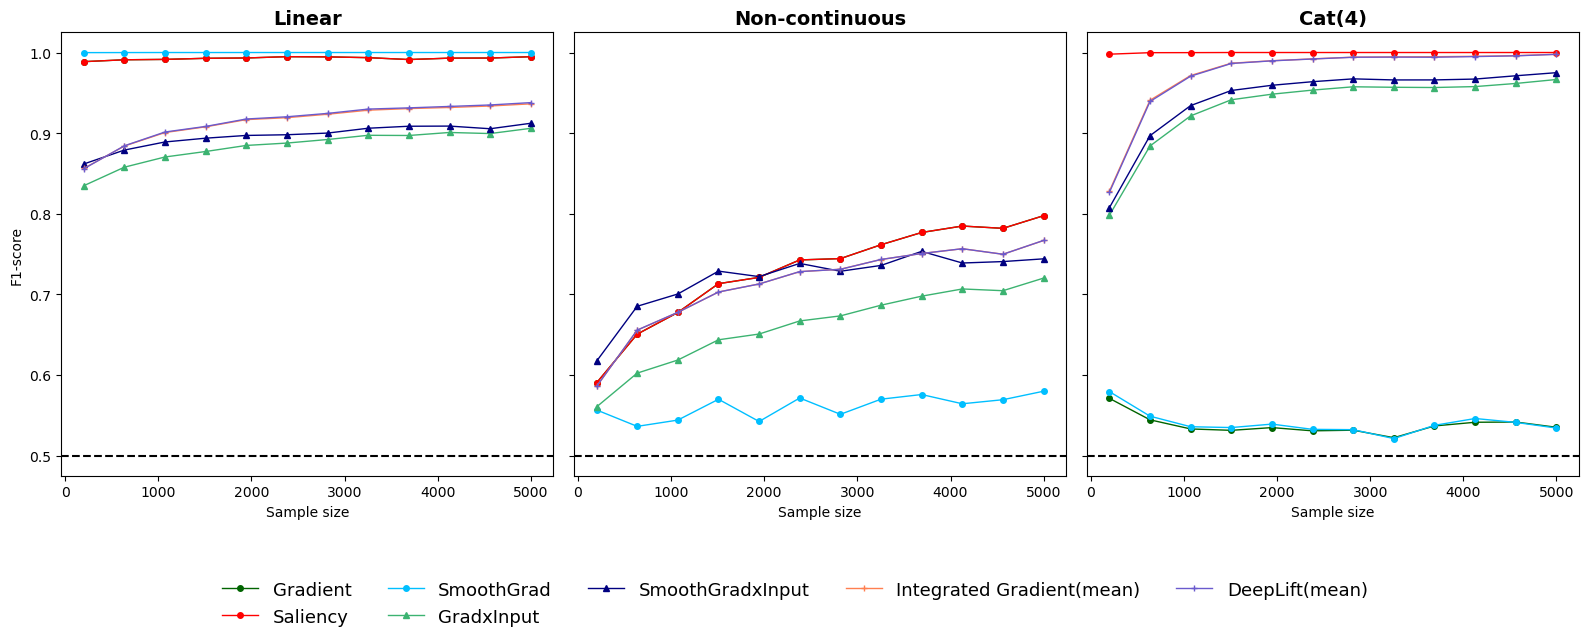

In [11]:
df = pd.DataFrame(data)
print(df)


method_colors = {
    "Gradient": 'darkgreen',
    "Saliency": 'red',
    "SmoothGrad": 'deepskyblue',
    "GradxInput": 'mediumseagreen',
    "SmoothGradxInput": 'navy',
    "Integrated Gradient(mean)": 'coral',
    "DeepLift(mean)": 'slateblue'
}

method_markers = ['o', 'o', 'o', '^', '^', '+', '+']


fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=True)

for ax, ftype in zip(axes, function_types):
    sub = df[df['Function'] == ftype]
    for i, method in enumerate(methods):
        method_df = sub[sub['Method'] == method]
        ax.plot(
            method_df['NumTrainSamples'],
            method_df['MeanScore'],
            label=method,
            color=method_colors[method],
            marker=method_markers[i % len(method_markers)],
            markersize=4,
            linewidth=1
        )
    ax.set_title(ftype, fontsize=14, fontweight='bold')
    ax.axhline(0.5, linestyle='--', color='black')
    ax.set_xlabel("Sample size")
    if ax is axes[0]:
        ax.set_ylabel("F1-score")


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='lower center',
    ncol=5,
    frameon=False,
    bbox_to_anchor=(0.5, -0.08),
    fontsize=13
)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

#### Print the mean model $R^2$ scores

In [12]:
for func in function_types:
            
    for train_samples in train_sample_space:

        relevant_scores = [s['Score'] for s in model_scores
                if s['Function'] == func and s['NumTrainSamples'] == train_samples]
        
        print(f"Avg Model score ({func}, {train_samples} Training samples): {np.mean(relevant_scores)}")     


Avg Model score (Linear, 200 Training samples): 0.8519418835639954
Avg Model score (Linear, 636 Training samples): 0.8719229102134705
Avg Model score (Linear, 1072 Training samples): 0.8697378039360046
Avg Model score (Linear, 1509 Training samples): 0.879946768283844
Avg Model score (Linear, 1945 Training samples): 0.8832364678382874
Avg Model score (Linear, 2381 Training samples): 0.8839100003242493
Avg Model score (Linear, 2818 Training samples): 0.8836866617202759
Avg Model score (Linear, 3254 Training samples): 0.8775169253349304
Avg Model score (Linear, 3690 Training samples): 0.8842998743057251
Avg Model score (Linear, 4127 Training samples): 0.881340503692627
Avg Model score (Linear, 4563 Training samples): 0.8905580639839172
Avg Model score (Linear, 5000 Training samples): 0.8853231072425842
Avg Model score (Non-continuous, 200 Training samples): 0.009705870412290096
Avg Model score (Non-continuous, 636 Training samples): 0.06456031650304794
Avg Model score (Non-continuous, 10